# Dataset 1: Breast Cancer Wisconsin

This notebook presents a benchmark of three classification models on the
Breast Cancer Wisconsin dataset, followed by model explainability analysis
and counterfactual explanations for the best-performing model.

## Dataset description

The Breast Cancer Wisconsin dataset contains measurements of cell nuclei
computed from digitized images of fine needle aspirates of breast masses.

The task is a binary classification problem:
- 0 — malignant
- 1 — benign

All features are continuous numerical variables, which allows for
straightforward preprocessing.

In [4]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [6]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
# The dataset contains 569 instances with 30 numerical features.
# The class distribution is moderately imbalanced (approximately 63% benign
# and 37% malignant)

X.shape, y.value_counts()

((569, 30),
 target
 1    357
 0    212
 Name: count, dtype: int64)

In [8]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Benchmark

In [73]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

In [76]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name

'Logistic Regression'

# XAI


## Feature importance

For logistic regression, **feature importance** is given by the absolute values
of model coefficients, which indicate the strength and direction of each
feature's influence on the prediction.

In [11]:
coefficients = best_model.named_steps["model"].coef_[0]

feature_importance = (
    pd.Series(coefficients, index=X.columns)
    .sort_values(key=abs, ascending=False)
)

feature_importance.head(10)

worst texture          -1.250149
radius error           -1.070102
worst symmetry         -0.957045
worst concave points   -0.941888
area error             -0.941059
worst area             -0.925812
worst radius           -0.917480
worst concavity        -0.796758
worst perimeter        -0.721168
mean compactness        0.694230
dtype: float64

## SHAP

In [87]:
# SHAP setup
scaler = best_model.named_steps["scaler"]
lr_model = best_model.named_steps["model"]

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


explainer = shap.LinearExplainer(
    lr_model,
    X_train_scaled
)

shap_values = explainer.shap_values(X_test_scaled)
shap_values


array([[ 2.21597767e-01,  2.24346067e-01,  2.05389627e-01, ...,
         5.22390982e-01, -1.46733300e-01,  3.84967147e-04],
       [-5.60431233e-01, -2.37982423e-01, -5.01227899e-01, ...,
        -1.11747346e+00, -1.30610372e-01,  6.42805608e-03],
       [-1.08227441e-01, -5.58530176e-02, -8.53467425e-02, ...,
        -4.37409967e-01,  1.30302571e-02,  9.89723676e-03],
       ...,
       [ 3.78302051e-01, -5.70205138e-02,  3.69179124e-01, ...,
         8.45456195e-01, -7.56473116e-01,  1.79327545e-01],
       [-3.95760401e-02,  9.02661352e-01, -3.02830362e-02, ...,
        -6.16223058e-02,  1.20027869e-01,  6.20468560e-02],
       [ 3.06665807e-01,  9.12515020e-02,  2.99898970e-01, ...,
         8.25685277e-01,  1.09033498e+00,  1.32549560e-01]],
      shape=(143, 30))

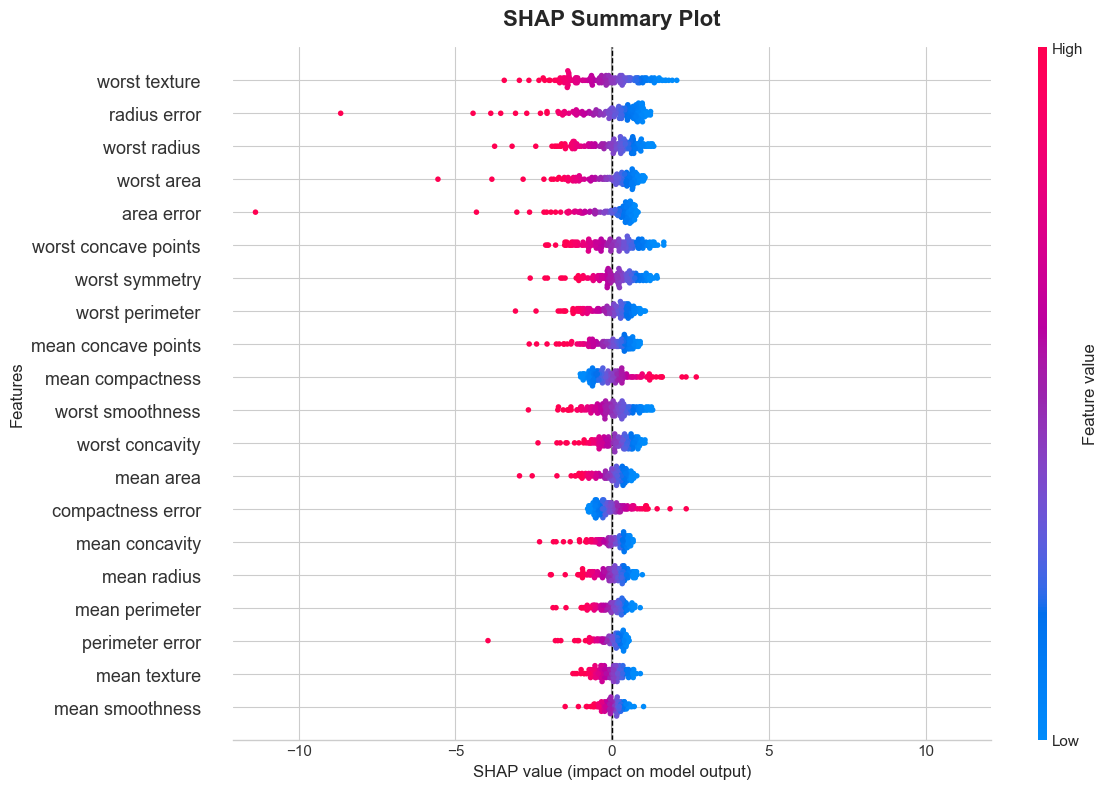

In [13]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()
ax.axvline(0, color="black", linestyle="--", linewidth=1)
max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)
plt.title(
    "SHAP Summary Plot",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()

## LIME

In [37]:
#LIME setup

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["malignant", "benign"],
    discretize_continuous=True,
    mode="classification"
)

index = 0
instance = X_test.iloc[index]
instance

mean radius                 12.750000
mean texture                16.700000
mean perimeter              82.510000
mean area                  493.800000
mean smoothness              0.112500
mean compactness             0.111700
mean concavity               0.038800
mean concave points          0.029950
mean symmetry                0.212000
mean fractal dimension       0.066230
radius error                 0.383400
texture error                1.003000
perimeter error              2.495000
area error                  28.620000
smoothness error             0.007509
compactness error            0.015610
concavity error              0.019770
concave points error         0.009199
symmetry error               0.018050
fractal dimension error      0.003629
worst radius                14.450000
worst texture               21.740000
worst perimeter             93.630000
worst area                 624.100000
worst smoothness             0.147500
worst compactness            0.197900
worst concav

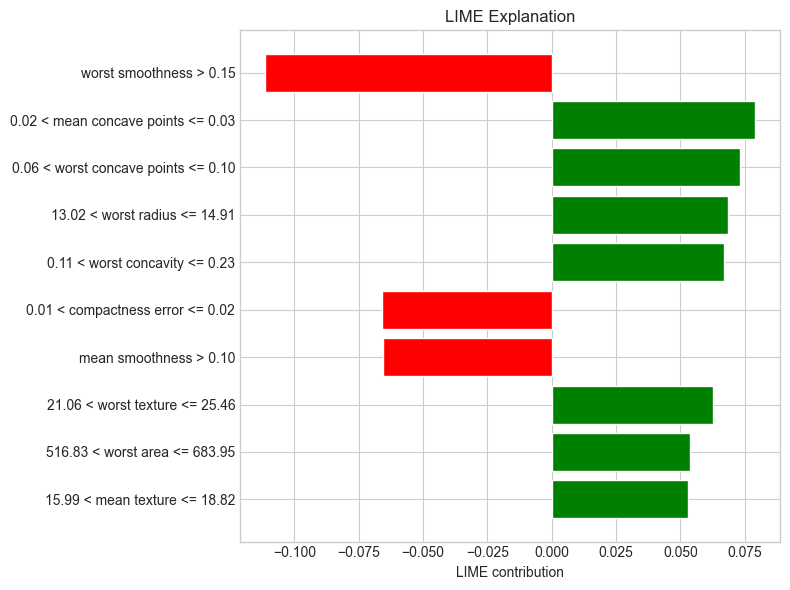

In [15]:
def predict_proba_pipeline(x):
    x_df = pd.DataFrame(x, columns=X.columns)
    return best_model.predict_proba(x_df)

lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_pipeline,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Counterfactual Explanations (DiCE)

In [38]:
#DiCE setup

df = X.copy()
df["target"] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=X.columns.tolist(),
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = instance.to_frame().T
query_instance

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
519,12.75,16.7,82.51,493.8,0.1125,0.1117,0.0388,0.02995,0.212,0.06623,...,14.45,21.74,93.63,624.1,0.1475,0.1979,0.1423,0.08045,0.3071,0.08557


In [43]:
cf = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=0
)


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


The heatmap illustrates feature-wise changes required to flip the model
prediction across multiple counterfactual scenarios. Larger required changes,
particularly in extreme geometric features such as worst area, indicate
higher stability of the original prediction.

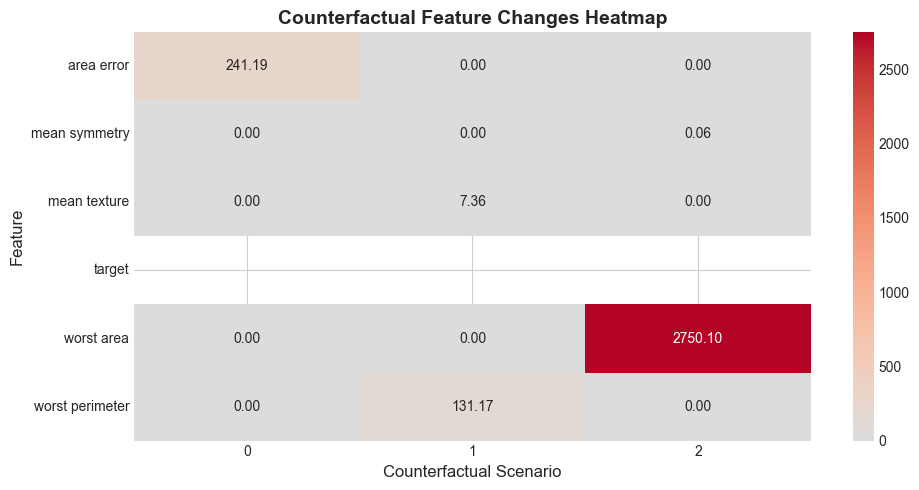

In [45]:
plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

## Evaluation

#### VALIDITY

In [77]:
desired_class = 0

In [89]:
#filter target
cf_features = cf_df[X.columns]

cf_preds = best_model.predict(cf_features)
validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(validity))],
    "Valid (prediction flipped)": validity
})

validity_df

,Counterfactual,Valid (prediction flipped)
0,CF_0,True
1,CF_1,True
2,CF_2,True


#### SPARSITY

In [84]:
sparsity = (cf_features != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(sparsity))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df

,Counterfactual,Sparsity (number of features changed)
0,CF_0,1
1,CF_1,2
2,CF_2,2


#### PROXIMITY


In [83]:
proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df

,Counterfactual,Proximity (L1 distance)
0,CF_0,241.1900
1,CF_1,138.5300
2,CF_2,2750.1611


#### PLAUSIBILITY

In [85]:
def plausible(cf_row, X):
    return ((cf_row >= X.min()) & (cf_row <= X.max())).all()

plausibility = cf_features.apply(lambda row: plausible(row, X), axis=1)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df

,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True


The generated counterfactual explanations were evaluated using multiple criteria.
All counterfactuals successfully flipped the model prediction, resulting in a
validity score of 100%. Sparsity analysis revealed that only one or two features
needed to be modified, indicating concise and interpretable explanations.

Proximity was measured using L1 distance, showing that some counterfactuals
required minimal changes, while others involved larger feature modifications.
Although all counterfactuals remained within the data range, extreme feature
changes may reduce their practical plausibility. Overall, the results indicate
a stable decision boundary with multiple valid counterfactual paths.